# EDA (Exploratory Data Analysis)

**Competition:** Kaggle Playground Series S5E10  
**Goal:** Predict the likelihood of accidents on different types of roads.  
**This notebook:** clean, simple EDA to support modeling.

**Target column (inferred):** `accident_risk`


## 1. Setup & Data Load

In [8]:

import pandas as pd
import matplotlib.pyplot as plt

train = pd.read_csv("../../data/train.csv")
test  = pd.read_csv("../../data/test.csv")
sample_sub = pd.read_csv("../../data/sample_submission.csv")
target_col = "accident_risk"

train.shape, test.shape, sample_sub.shape


((517754, 14), (172585, 13), (172585, 2))

## 2. Preview

In [9]:
train.head(10)

,id,road_type,num_lanes,curvature,speed_limit,lighting,weather,road_signs_present,public_road,time_of_day,holiday,school_season,num_reported_accidents,accident_risk
0,0,urban,2,0.06,35,daylight,rainy,False,True,afternoon,False,True,1,0.13
1,1,urban,4,0.99,35,daylight,clear,True,False,evening,True,True,0,0.35
2,2,rural,4,0.63,70,dim,clear,False,True,morning,True,False,2,0.30
3,3,highway,4,0.07,35,dim,rainy,True,True,morning,False,False,1,0.21
4,4,rural,1,0.58,60,daylight,foggy,False,False,evening,True,False,1,0.56
5,5,highway,3,0.54,70,night,foggy,True,False,morning,False,True,0,0.61
6,6,highway,1,0.04,45,night,foggy,False,True,morning,True,False,2,0.20
7,7,highway,2,0.33,45,daylight,clear,False,True,evening,False,True,0,0.16
8,8,rural,3,0.63,25,dim,clear,True,False,evening,True,True,2,0.18
9,9,urban,4,0.38,45,dim,clear,True,True,afternoon,True,True,2,0.15


## 3. Target Distribution

,share
accident_risk,
0.34,0.030018
0.32,0.027503
0.37,0.025983
0.28,0.025663
0.39,0.024141
...,...
0.94,0.000091
0.97,0.000054
0.96,0.000054


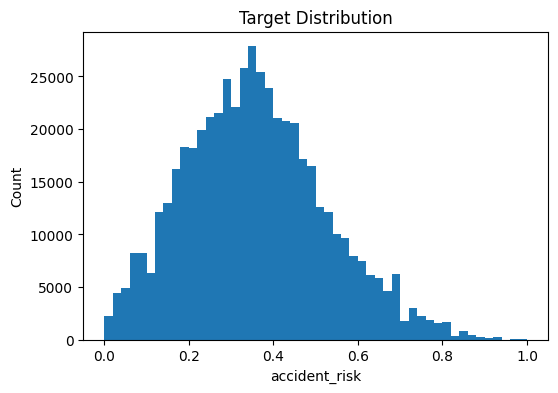

In [10]:

target_share = train[target_col].value_counts(normalize=True).rename('share').to_frame()
display(target_share)

# Plot histogram for continuous target
plt.figure(figsize=(6,4))
plt.hist(train[target_col], bins=50)
plt.title('Target Distribution')
plt.xlabel(target_col)
plt.ylabel('Count')
plt.show()


## 4. Dtypes & Missing Values

In [11]:
dtypes = train.dtypes.to_frame(name='dtype')
nulls  = train.isna().mean().to_frame(name='null_share')
overview = dtypes.join(nulls, how='left').sort_index()
overview.head(40)

,dtype,null_share
accident_risk,float64,0.0
curvature,float64,0.0
holiday,bool,0.0
id,int64,0.0
lighting,object,0.0
num_lanes,int64,0.0
num_reported_accidents,int64,0.0
public_road,bool,0.0
road_signs_present,bool,0.0
road_type,object,0.0


## 5. Feature Split (Numeric vs Categorical)

In [12]:
feature_cols = [c for c in train.columns if c != target_col]
cat_cols = [c for c in feature_cols if train[c].dtype == 'object']
num_cols = [c for c in feature_cols if c not in cat_cols]
print(f"Numeric: {len(num_cols)} | Categorical: {len(cat_cols)}")
print("Numeric sample:", num_cols[:12])
print("Categorical sample:", cat_cols[:12])


Numeric: 9 | Categorical: 4
Numeric sample: ['id', 'num_lanes', 'curvature', 'speed_limit', 'road_signs_present', 'public_road', 'holiday', 'school_season', 'num_reported_accidents']
Categorical sample: ['road_type', 'lighting', 'weather', 'time_of_day']


## 6. Simple Numeric Summary

In [13]:

train[num_cols].describe().T.head(20)


,count,mean,std,min,25%,50%,75%,max
id,517754.0,258876.500000,149462.849975,0.0,129438.25,258876.50,388314.75,517753.0
num_lanes,517754.0,2.491511,1.120434,1.0,1.00,2.00,3.00,4.0
curvature,517754.0,0.488719,0.272563,0.0,0.26,0.51,0.71,1.0
speed_limit,517754.0,46.112575,15.788521,25.0,35.00,45.00,60.00,70.0
num_reported_accidents,517754.0,1.187970,0.895961,0.0,1.00,1.00,2.00,7.0



### Quick conclusions
- We'll use median imputation for numeric, most_frequent + OneHot for categorical.
- Evaluation metric: **ROC AUC** with **Stratified K-Fold (5 folds)**.
- For interpretability: **Permutation Importance** on a small holdout split.
